In [1]:
import anndata as ad
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

import omicverse as ov
print(f'omicverse version:{ov.__version__}')
import scanpy as sc
print(f'scanpy version:{sc.__version__}')
ov.ov_plot_set()


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.7, Tutorials: https://omicverse.readthedocs.io/
omicverse version:1.5.7
scanpy version:1.9.8


## Loading data

In [2]:
def prepare_figures_directory(disease_name, dataset_name):
    if not os.path.exists(FIGURES_DIR):
        os.mkdir(FIGURES_DIR)
        os.mkdir(os.path.join(FIGURES_DIR, 'X_mde'))

    if not os.path.exists(os.path.join(FIGURES_DIR, 'X_mde', DISEASE_NAME)):
        os.mkdir(os.path.join(FIGURES_DIR, 'X_mde', DISEASE_NAME))
    
    if not os.path.exists(DEG_RESULTS_DIR):
        os.mkdir(DEG_RESULTS_DIR)

    if not os.path.exists(os.path.join(DEG_RESULTS_DIR, DISEASE_NAME)):
        os.mkdir(os.path.join(DEG_RESULTS_DIR, DISEASE_NAME))
        
    os.mkdir(os.path.join(FIGURES_DIR, 'X_mde', DISEASE_NAME, dataset_name))
    os.mkdir(os.path.join(DEG_RESULTS_DIR, DISEASE_NAME, dataset_name))

    return

In [3]:
def initialize_adata_of_case_control(dataset_dir):    
    CASE_DIR_PATHS = []
    CONTROL_DIR_PATHS = []
    
    for dir_name in os.listdir(dataset_dir):
        if dir_name.startswith('Case'):
            CASE_DIR_PATHS.append(os.path.join(dataset_dir, dir_name))
        else:
            CONTROL_DIR_PATHS.append(os.path.join(dataset_dir, dir_name))

    print(f'\n==============================================\n Found {len(CASE_DIR_PATHS)} Cases and {len(CONTROL_DIR_PATHS)} Control Donors\n==============================================\n')
    
    adata = None

    for idx, case_path in enumerate(CASE_DIR_PATHS):
        print(f'Building Case Adata No. {idx + 1} out of {len(CASE_DIR_PATHS)}')
        adata_case = sc.read_10x_mtx(case_path, var_names='gene_symbols', cache=True)
        adata_case.obs['donor'] = 'Case'
        if adata is None:
            adata = adata_case
        else:
            adata = ad.concat([adata, adata_case])
    
    for idx, control_path in enumerate(CONTROL_DIR_PATHS):
        print(f'Building Control Adata No. {idx + 1} out of {len(CONTROL_DIR_PATHS)}')
        adata_control = sc.read_10x_mtx(control_path, var_names='gene_symbols', cache=True)
        adata_control.obs['donor'] = 'Control'
        adata = ad.concat([adata, adata_control])

    print('\n==============================================\n', adata, '\n==============================================\n')
    return adata

In [4]:
def preprocess_adata(adata):
    #quantity control
    adata = ov.pp.qc(adata, tresh = {'mito_perc': 0.05, 'nUMIs': 500, 'detected_genes': 250})
    
    #normalize and high variable genes (HVGs) calculated
    adata = ov.pp.preprocess(adata, mode='shiftlog|pearson', n_HVGs=2000,)
    
    #save the whole genes and filter the non-HVGs
    adata.raw = adata
    adata = adata[:, adata.var.highly_variable_features]
    
    #scale the adata.X
    ov.pp.scale(adata)
    
    #Dimensionality Reduction
    ov.pp.pca(adata,layer='scaled', n_pcs=50)
    
    #Neighbourhood graph construction
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, use_rep='scaled|original|X_pca')
    
    #clusters
    sc.tl.leiden(adata)
    
    #Dimensionality Reduction for visualization(X_mde=X_umap+GPU)
    adata.obsm["X_mde"] = ov.utils.mde(adata.obsm["scaled|original|X_pca"])
    return adata

## Cell annotate automatically

We create a pySCSA object from the `adata`, and we need to set some parameter to annotate correctly.

In normal annotate, we set `celltype`=`'normal'` and `target`=`'cellmarker'` or `'panglaodb'` to perform the cell annotate.

But in cancer annotate, we need to set the `celltype`=`'cancer'` and `target`=`'cancersea'` to perform the cell annotate.

<div class="admonition note">
  <p class="admonition-title">Note</p>
  <p>
    The annotation with SCSA need to download the database at first. It can be downloaded automatically. But sometimes you will have problems with network errors.
  </p>
</div>

The database can be downloaded from [figshare](https://figshare.com/ndownloader/files/41369037) or [Google Drive](https://drive.google.com/drive/folders/1pqyuCp8mTXDFRGUkX8iDdPAg45JHvheF?usp=sharing). And you need to set parameter `model_path`=`'path'`

In [5]:
def cell_type_annotation_SCSA(adata):
    scsa = ov.single.pySCSA(adata=adata, foldchange=1.5, pvalue=0.01,
                            celltype='normal', target='cellmarker', tissue='All')
    
    anno = scsa.cell_anno(clustertype='leiden', cluster='all', rank_rep=True)

    scsa.cell_auto_anno(adata, key='scsa_celltype_cellmarker')

    # panglaodb
    scsa = ov.single.pySCSA(adata=adata, foldchange=1.5, pvalue=0.01,
                            celltype='normal', target='panglaodb',
                            tissue='All', model_path='temp/pySCSA_2023_v2_plus.db')

    """
    In the previous cell clustering we used the leiden algorithm, so here we specify that the type is set to leiden.
    if you are using louvain, please change it. And, we will annotate all clusters,
    if you only want to annotate a few of the classes, please follow `'[1]'`, `'[1,2,3]'`, `'[...]'` Enter in the format.
    `rank_rep` means the `sc.tl.rank_genes_groups(adata, clustertype, method='wilcoxon')`,
    if we provided the `rank_genes_groups` in adata.uns, `rank_rep` can be set as `False`
    """
    res = scsa.cell_anno(clustertype='leiden', cluster='all', rank_rep=True)

    # scsa.cell_anno_print()
    
    scsa.cell_auto_anno(adata,key='scsa_celltype_panglaodb')
    return

In [6]:
def plot_cell_type_annotated_adata_embeddings(adata, disease_name, dataset_name):
    ov.utils.embedding(adata, basis='X_mde',
                       color=['leiden'],
                       legend_loc='on data', frameon='small', legend_fontoutline=0.01,
                       palette=ov.utils.palette(),
                       save=f'/{disease_name}/{dataset_name}/leiden.png')

    ov.utils.embedding(adata, basis='X_mde',
                       color=['scsa_celltype_cellmarker'],
                       legend_loc='on data', frameon='small', legend_fontoutline=0.01,
                       palette=ov.utils.palette(),
                       save=f'/{disease_name}/{dataset_name}/SCSA_cellType_cellmarker.png')

    ov.utils.embedding(adata, basis='X_mde',
                       color=['scsa_celltype_panglaodb'],
                       legend_loc='on data', frameon='small', legend_fontoutline=0.01,
                       palette=ov.utils.palette(),
                       save=f'/{disease_name}/{dataset_name}/SCSA_cellType_panglaodb.png')

    """
    If you want to draw stacked histograms of cell type proportions, you first need to colour the groups you intend to draw
    using `ov.utils.embedding`. Then use `ov.utils.plot_cellproportion` to specify the groups you want to plot,
    and you can see a plot of cell proportions in the different groups
    """
    ov.utils.embedding(adata,
                       basis='X_mde',
                       color=['donor'],
                       frameon='small', legend_fontoutline=2,
                       palette=ov.utils.red_palette(),
                       save=f'/{disease_name}/{dataset_name}/donor_cells.png')

    # ov.utils.plot_cellproportion(adata=adata, celltype_clusters='scsa_celltype_cell|marker',
    #                              visual_clusters='donor',
    #                              visual_name='Donor', figsize=(2,4))

    ov.utils.plot_embedding_celltype(adata, figsize=(12, 8), basis='X_mde',
                                     celltype_key='scsa_celltype_cellmarker',
                                     title='            Cell type',
                                     celltype_range=(2, 6),
                                     embedding_range=(4, 10))
    
    plt.savefig(f'./{FIGURES_DIR}/X_mde/{disease_name}/{dataset_name}/embedding_cell_types.png')
    return

In [7]:
def calculate_roe(adata):
    """
    We calculated the ratio of observed to expected cell numbers (Ro/e) for each cluster in different tissues
    to quantify the tissue preference of each cluster (Guo et al., 2018; Zhang et al., 2018).
    The expected cell num- bers for each combination of cell clusters and tissues were obtained from the chi-square test.
    One cluster was identified as being enriched in a specific tissue if Ro/e > 1
    """
    roe = ov.utils.roe(adata, sample_key='donor', cell_type_key='scsa_celltype_cellmarker')
    return roe

In [8]:
def plot_ROE(roe, plot_name):
    fig, ax = plt.subplots(figsize=(6, 6))

    transformed_roe = roe.copy()
    transformed_roe = transformed_roe.applymap(lambda x: '+++' if x >= 2 else ('++' if x >= 1.5 else ('+' if x >= 1 else '+/-')))
    
    sns.heatmap(roe, annot=transformed_roe, cmap='RdBu_r', fmt='', cbar=True, ax=ax, vmin=0.5, vmax=1.5, cbar_kws={'shrink':0.5})
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.xlabel('Donor', fontsize=13)
    plt.ylabel('Cell type', fontsize=13)
    plt.title('Ro/e', fontsize=13)
    plt.savefig(plot_name)
    return

In [9]:
def perform_differential_gene_expression(adata, dataset_name, specific_celltype='All'):
    # List of Scanpy methods for DGE analysis
    methods = ['t-test', 'wilcoxon', 'logreg', 't-test_overestim_var']
    
    # Create an empty DataFrame to store results
    all_results = pd.DataFrame()
    
    for method in methods:
        print(f'===============================================\nPerforming {method}')
        
        sub_adata = adata.copy()
    
        if specific_celltype != 'All':
            sub_adata = sub_adata[sub_adata.obs['scsa_celltype_cellmarker'] == specific_celltype]        
    
        sc.tl.rank_genes_groups(sub_adata, groupby='donor', method=method)
    
        result = sub_adata.uns['rank_genes_groups']
        
        donors = result['names'].dtype.names
    
        out = np.array([[0, 0, 0, 0, 0, 0, 0]])
        
        for donor in donors:
            if 'pvals_adj' in result.keys():
                out = np.vstack(
                    (out, np.vstack(
                        (result['names'][donor],
                         np.array([specific_celltype] * len(result['names'][donor])).astype('object'),
                         np.array([donor] * len(result['names'][donor])).astype('object'),
                         np.array([result['params']['method']] * len(result['names'][donor])).astype('object'),
                         result['scores'][donor],
                         result['pvals_adj'][donor],
                         result['logfoldchanges'][donor],
                        )
                    ).T)
                )
            else:
                out = np.vstack(
                    (out, np.vstack(
                        (result['names'][donor],
                         np.array([specific_celltype] * len(result['names'][donor])).astype('object'),
                         np.array([donor] * len(result['names'][donor])).astype('object'),
                         np.array([result['params']['method']] * len(result['names'][donor])).astype('object'),
                         result['scores'][donor],
                         np.array([np.NaN] * len(result['names'][donor])).astype('object'),
                         np.array([np.NaN] * len(result['names'][donor])).astype('object'),
                        )
                    ).T)
                )    
            
        results_df = pd.DataFrame(out[1:], columns=['Gene', 'Target Cell Type', 'Donor', 'Method', 'Score', 'pval_adj', 'LFC'])
        all_results = pd.concat([all_results, results_df])
    print("===============================================\nGenerating DataFrame\n===============================================\n")
    all_results.to_csv(f'{DEG_RESULTS_DIR}/{DISEASE_NAME}/{dataset_name}/DEG_{specific_celltype}.csv', index=False)
    return

In [10]:
def run_pipeline_over_disease(disease_name, specific_celltype='All'):
    DISEASE_DIR = f'./data/{disease_name}'    
    DATASET_NAMES = os.listdir(DISEASE_DIR)
    DATASET_NAMES.sort()

    for dataset_name in DATASET_NAMES:
        print(f'\n\t\t====================================================================\n\t\t\t\tProcessing {dataset_name} from {disease_name}\n\t\t====================================================================\n')
        
        prepare_figures_directory(disease_name, dataset_name)

        dataset_dir = os.path.join(DISEASE_DIR, dataset_name)

        adata = initialize_adata_of_case_control(dataset_dir)

        adata = preprocess_adata(adata)

        cell_type_annotation_SCSA(adata)

        plot_cell_type_annotated_adata_embeddings(adata, disease_name, dataset_name)
        try:
            roe = calculate_roe(adata)
    
            plot_ROE(roe=roe, plot_name=f'./{FIGURES_DIR}/X_mde/{disease_name}/{dataset_name}/ROE.png')
        except:
            pass
            
        perform_differential_gene_expression(adata, dataset_name, specific_celltype)
    print("Done!")
    return

## Disease Name Specification

In [15]:
FIGURES_DIR = 'figures'
DEG_RESULTS_DIR = 'DEG_results'
DISEASE_NAME = 'MPN'


				Processing Dataset1 from MPN


 Found 1 Cases and 1 Control Donors

Building Case Adata No. 1 out of 1
... reading from cache file cache/data-MPN-Dataset1-Case5-matrix.h5ad
Building Control Adata No. 1 out of 1
... reading from cache file cache/data-MPN-Dataset1-Control3-matrix.h5ad

 AnnData object with n_obs × n_vars = 25152 × 36601
    obs: 'donor' 

Calculate QC metrics
End calculation of QC metrics.
Original cell number: 25152
Begin of post doublets removal and QC plot
Running Scrublet
filtered out 13657 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.20
Detected doublet rate = 4.3%
Estimated detectable doublet fraction = 39.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 10.9%


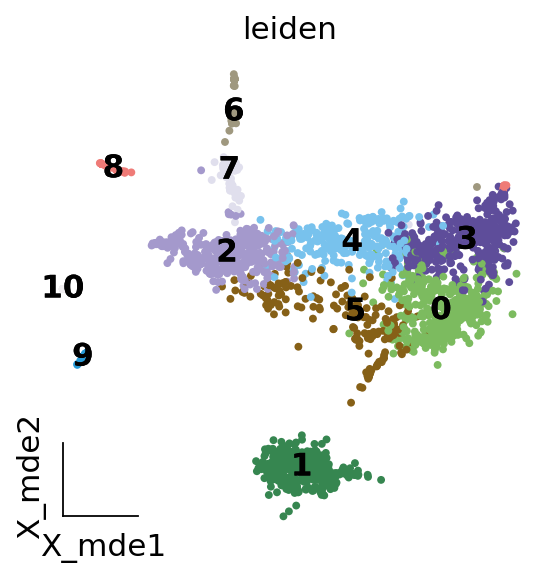

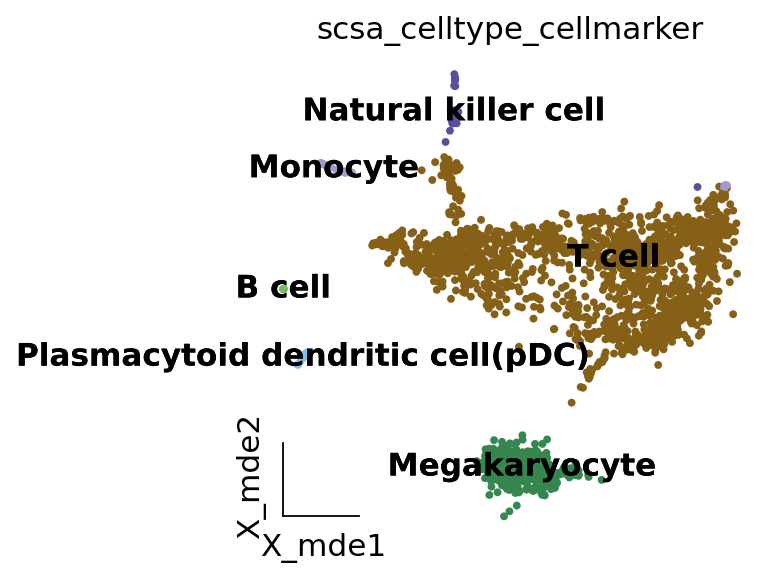

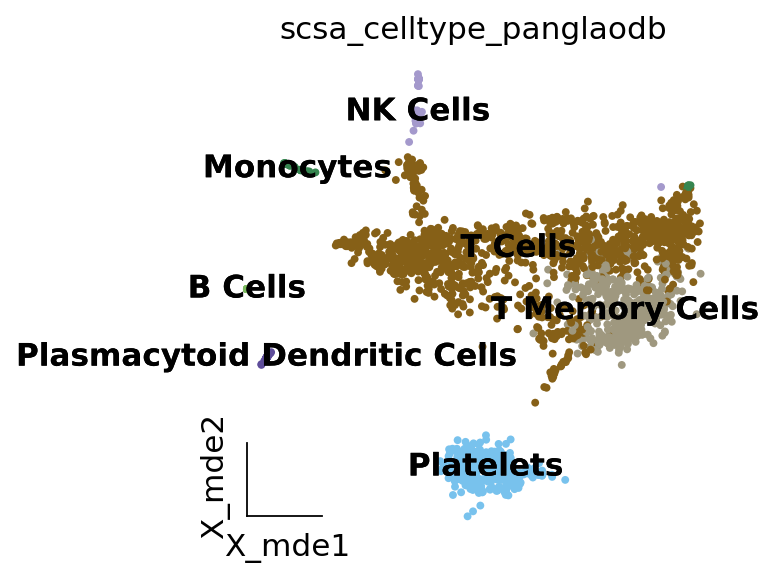

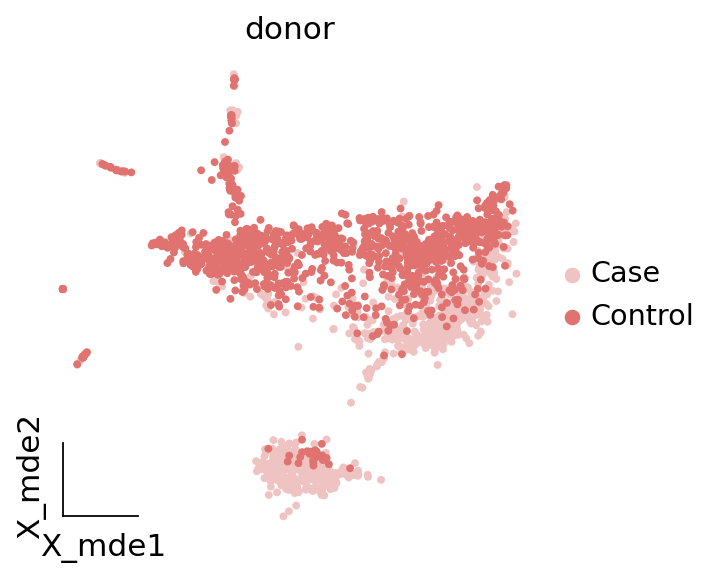

chi2: 477.156418332131, dof: 5, pvalue: 6.797322286631841e-101
Performing t-test
ranking genes
    finished (0:00:00)
Performing wilcoxon
ranking genes
    finished (0:00:01)
Performing logreg
ranking genes
    finished (0:00:00)
Performing t-test_overestim_var
ranking genes
    finished (0:00:00)
Generating DataFrame


				Processing Dataset2 from MPN


 Found 1 Cases and 1 Control Donors

Building Case Adata No. 1 out of 1
... reading from cache file cache/data-MPN-Dataset2-Case3-matrix.h5ad
Building Control Adata No. 1 out of 1
... reading from cache file cache/data-MPN-Dataset2-Control3-matrix.h5ad

 AnnData object with n_obs × n_vars = 26255 × 36601
    obs: 'donor' 

Calculate QC metrics
End calculation of QC metrics.
Original cell number: 26255
Begin of post doublets removal and QC plot
Running Scrublet
filtered out 13620 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normali

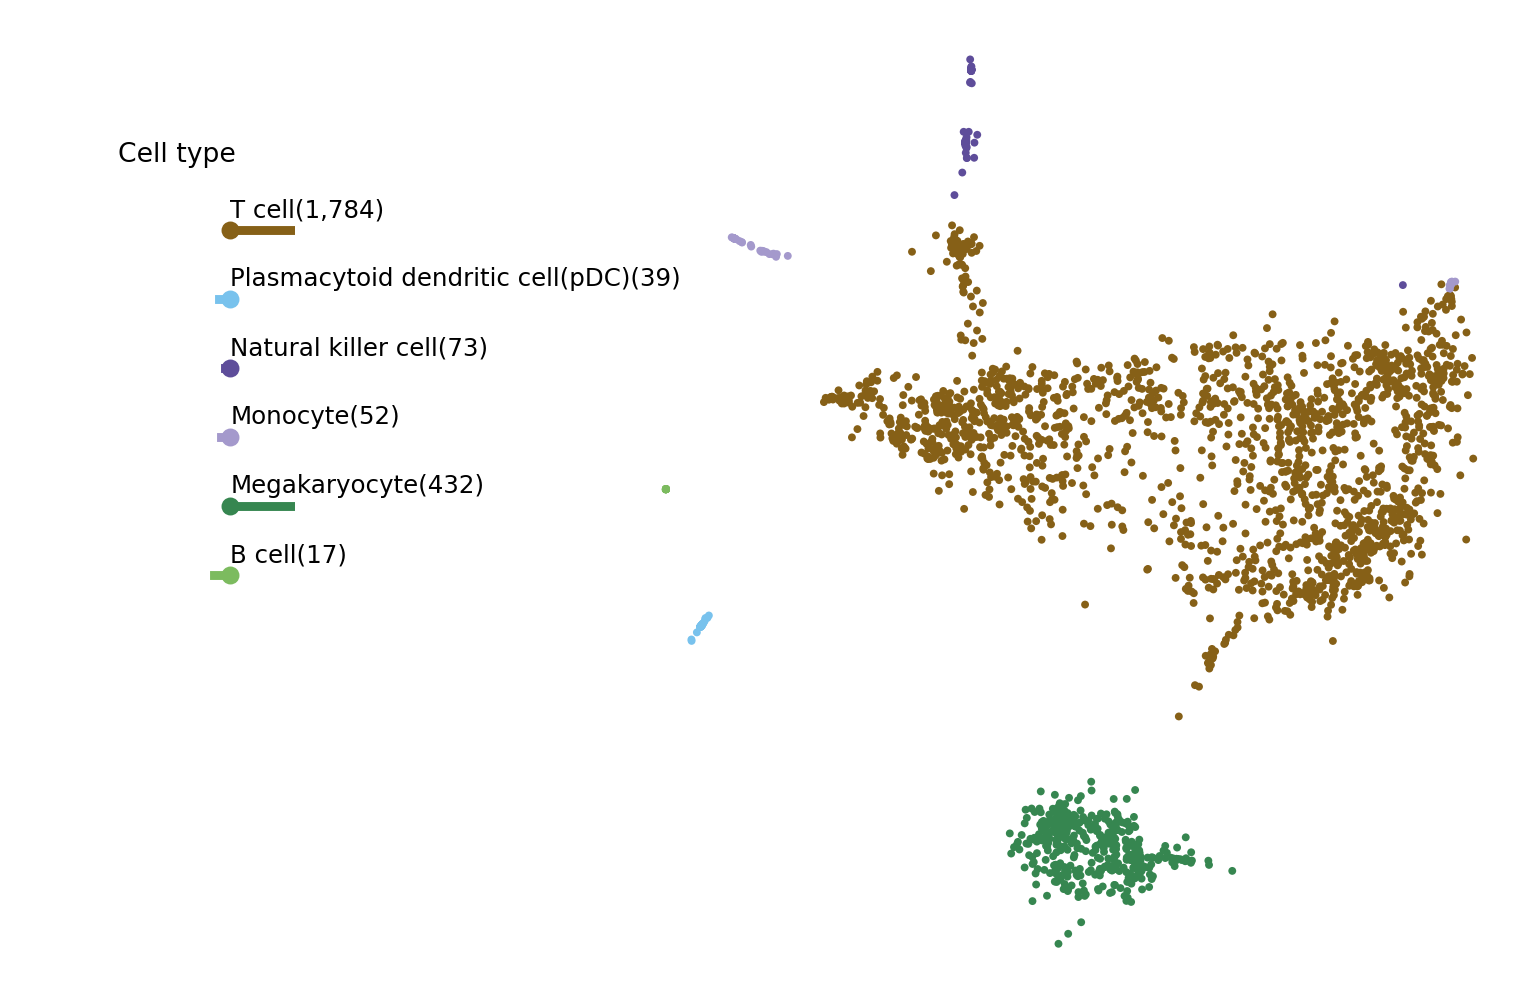

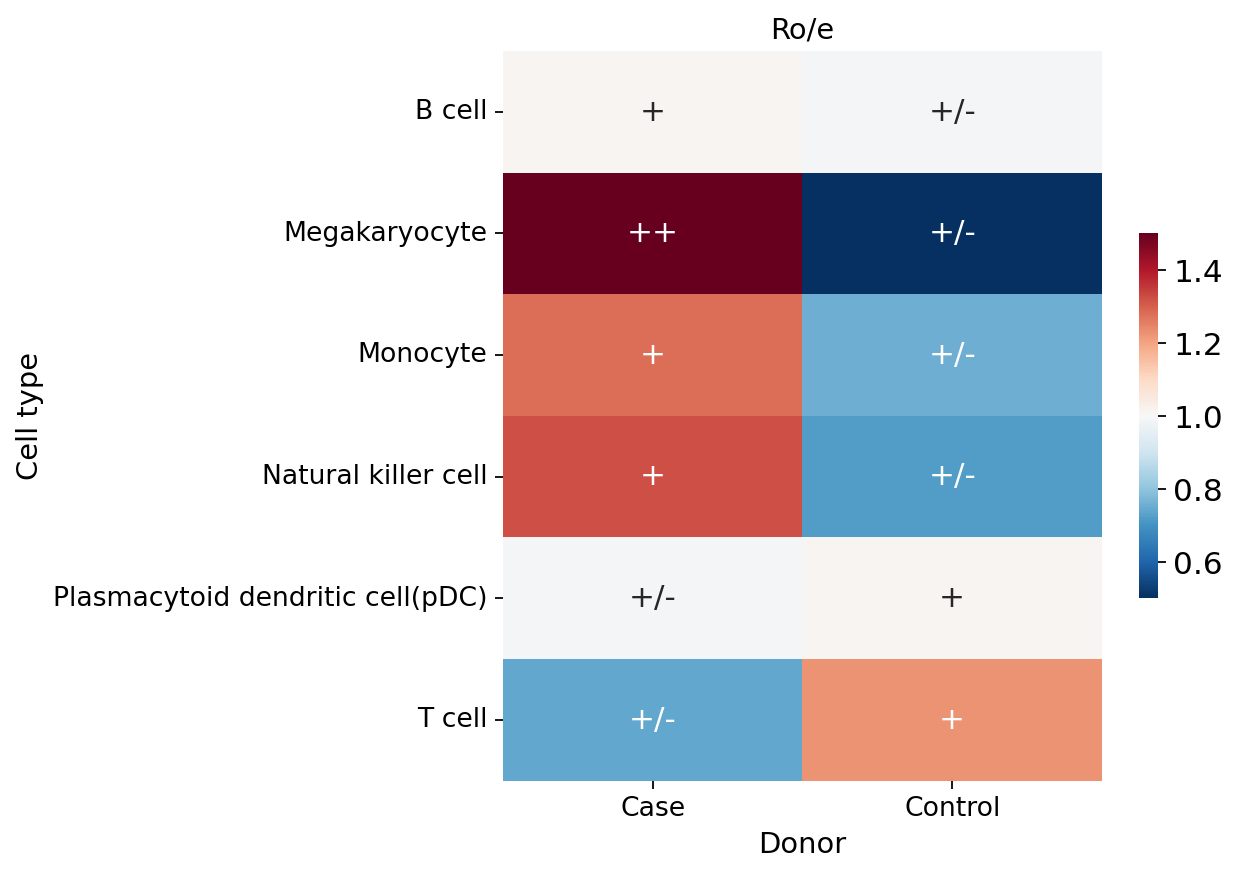

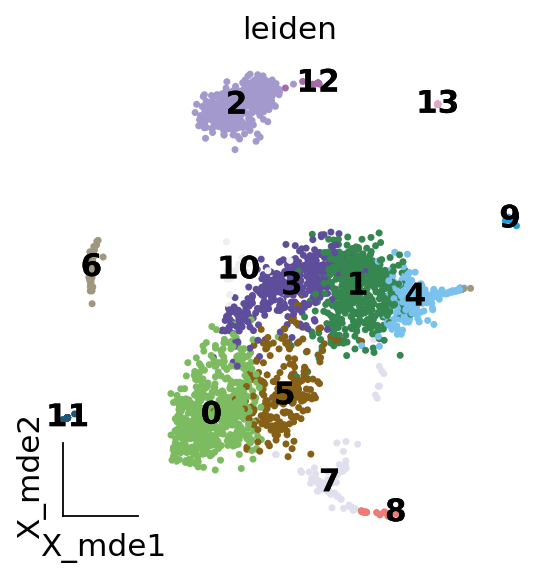

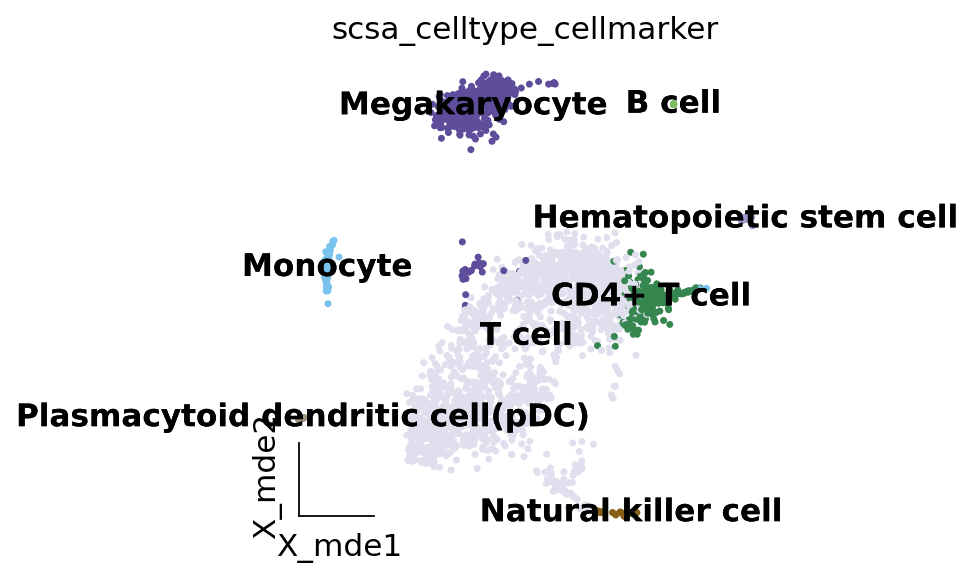

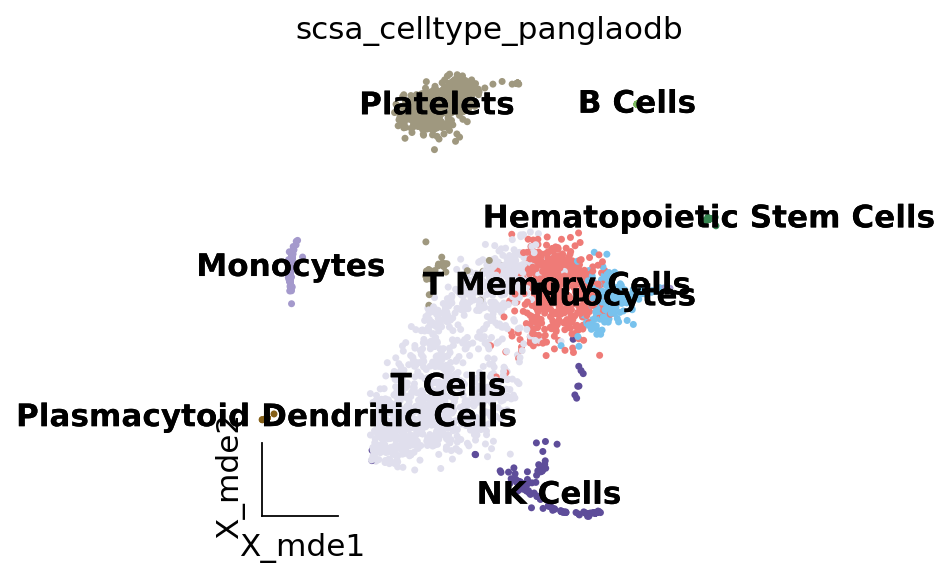

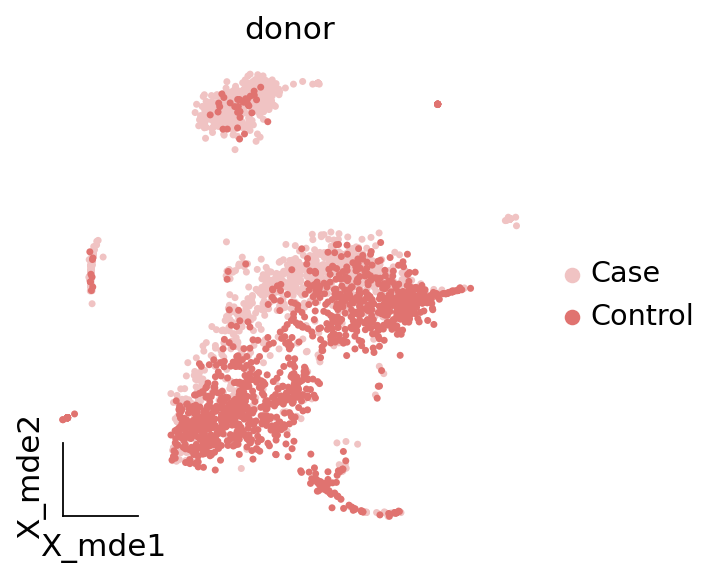

chi2: 622.9893446458219, dof: 7, pvalue: 2.723462193184844e-130
Performing t-test
ranking genes
    finished (0:00:00)
Performing wilcoxon
ranking genes
    finished (0:00:01)
Performing logreg
ranking genes
    finished (0:00:00)
Performing t-test_overestim_var
ranking genes
    finished (0:00:00)
Generating DataFrame


				Processing Dataset3 from MPN


 Found 1 Cases and 1 Control Donors

Building Case Adata No. 1 out of 1
... reading from cache file cache/data-MPN-Dataset3-Case2-matrix.h5ad
Building Control Adata No. 1 out of 1
... reading from cache file cache/data-MPN-Dataset3-Control3-matrix.h5ad

 AnnData object with n_obs × n_vars = 18874 × 36601
    obs: 'donor' 

Calculate QC metrics
End calculation of QC metrics.
Original cell number: 18874
Begin of post doublets removal and QC plot
Running Scrublet
filtered out 14254 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normal

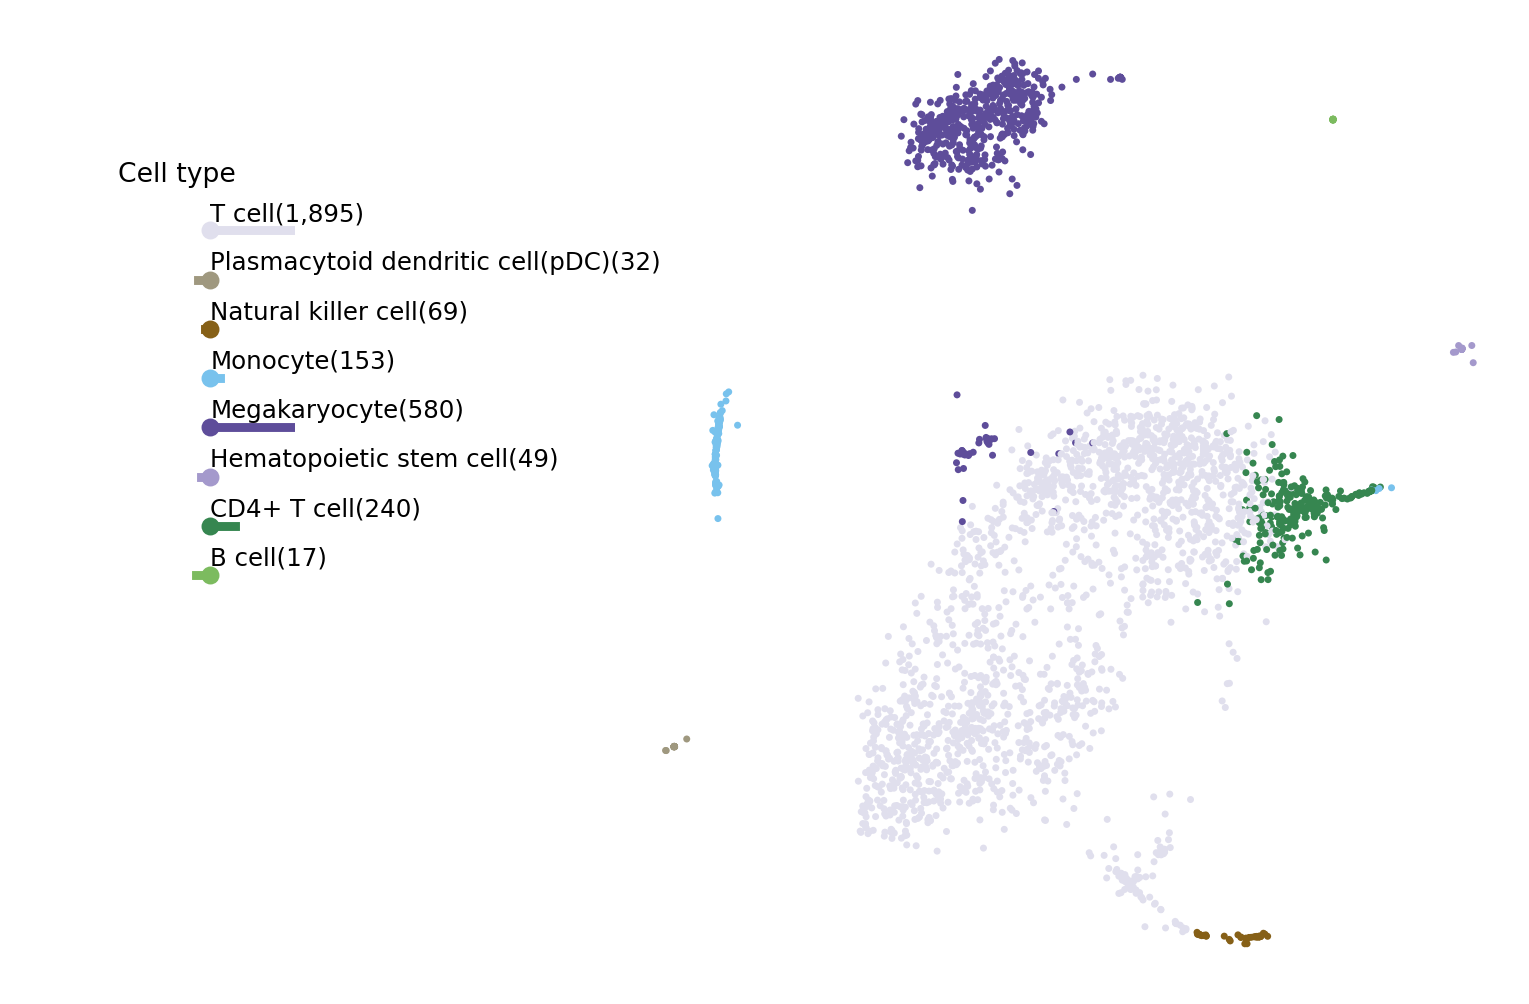

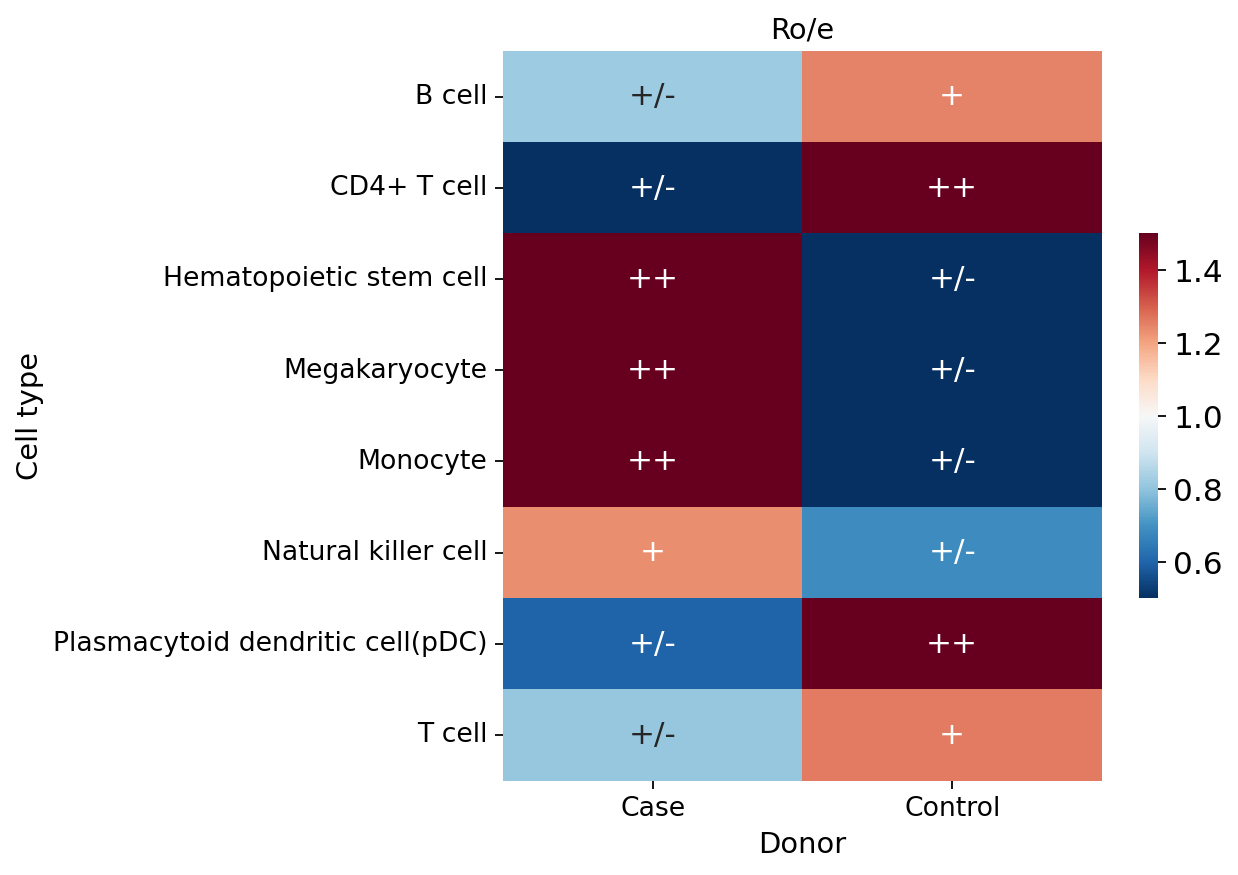

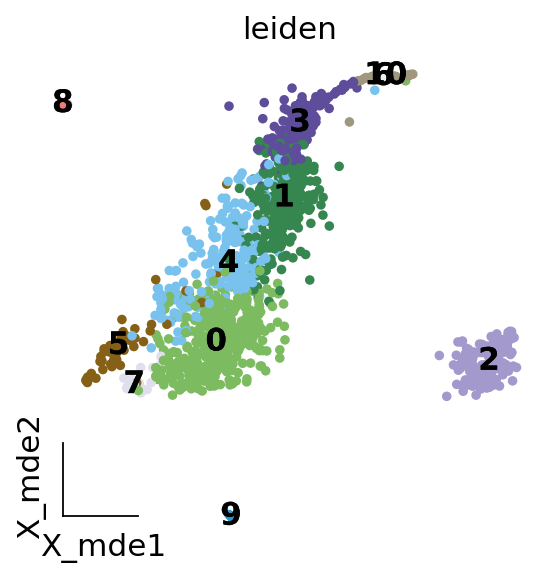

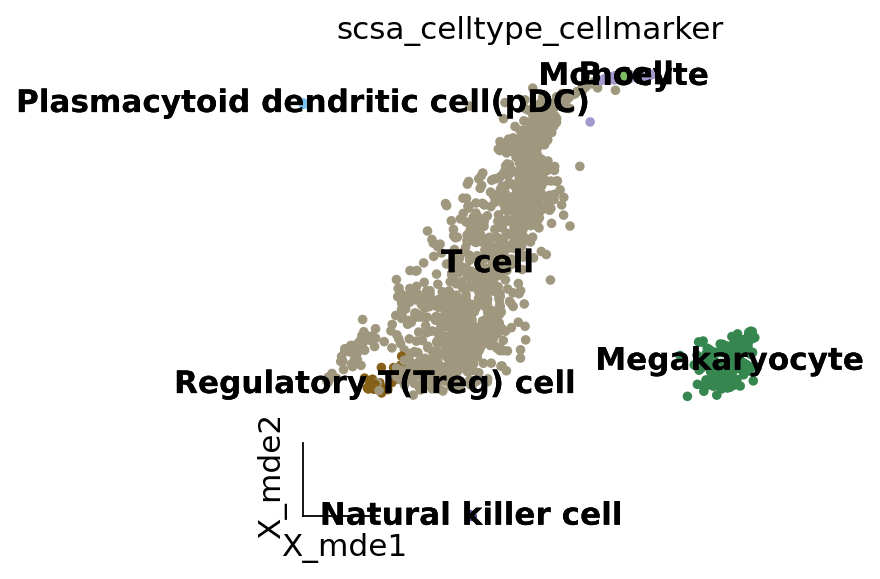

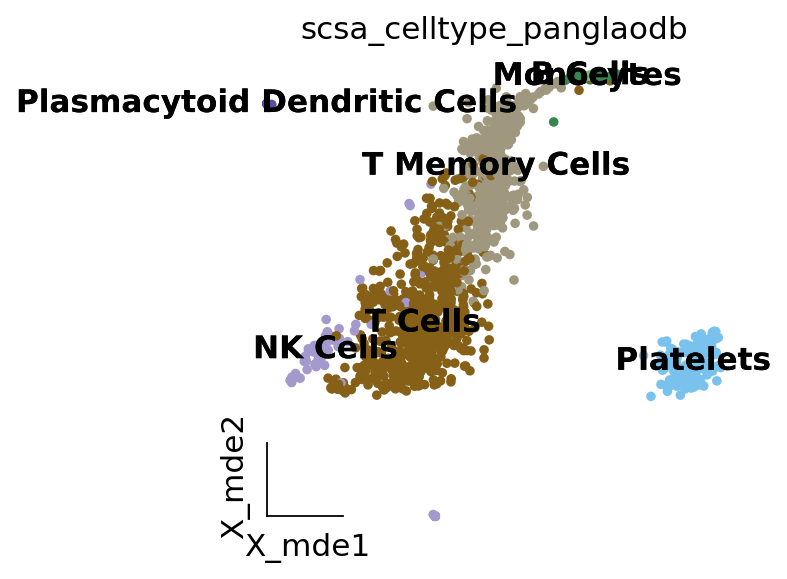

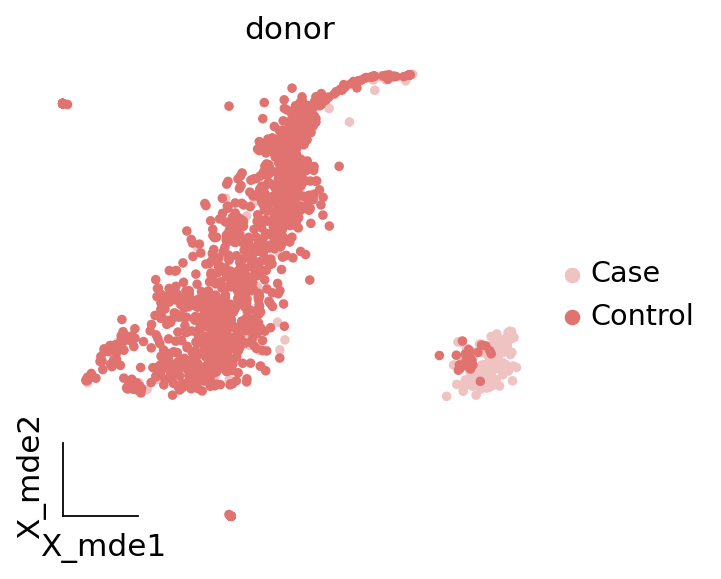

chi2: 948.752904513291, dof: 6, pvalue: 1.081363475431006e-201
Some expected frequencies are less than 5, it is suggested to use other statistical methods, such as Fisher's exact test
Performing t-test
ranking genes
    finished (0:00:00)
Performing wilcoxon
ranking genes
    finished (0:00:00)
Performing logreg
ranking genes
    finished (0:00:00)
Performing t-test_overestim_var
ranking genes
    finished (0:00:00)
Generating DataFrame


				Processing Dataset4 from MPN


 Found 1 Cases and 1 Control Donors

Building Case Adata No. 1 out of 1
... reading from cache file cache/data-MPN-Dataset4-Case2-matrix.h5ad
Building Control Adata No. 1 out of 1
... reading from cache file cache/data-MPN-Dataset4-Control2-matrix.h5ad

 AnnData object with n_obs × n_vars = 19947 × 36601
    obs: 'donor' 

Calculate QC metrics
End calculation of QC metrics.
Original cell number: 19947
Begin of post doublets removal and QC plot
Running Scrublet
filtered out 14057 genes that are detected in less than 3

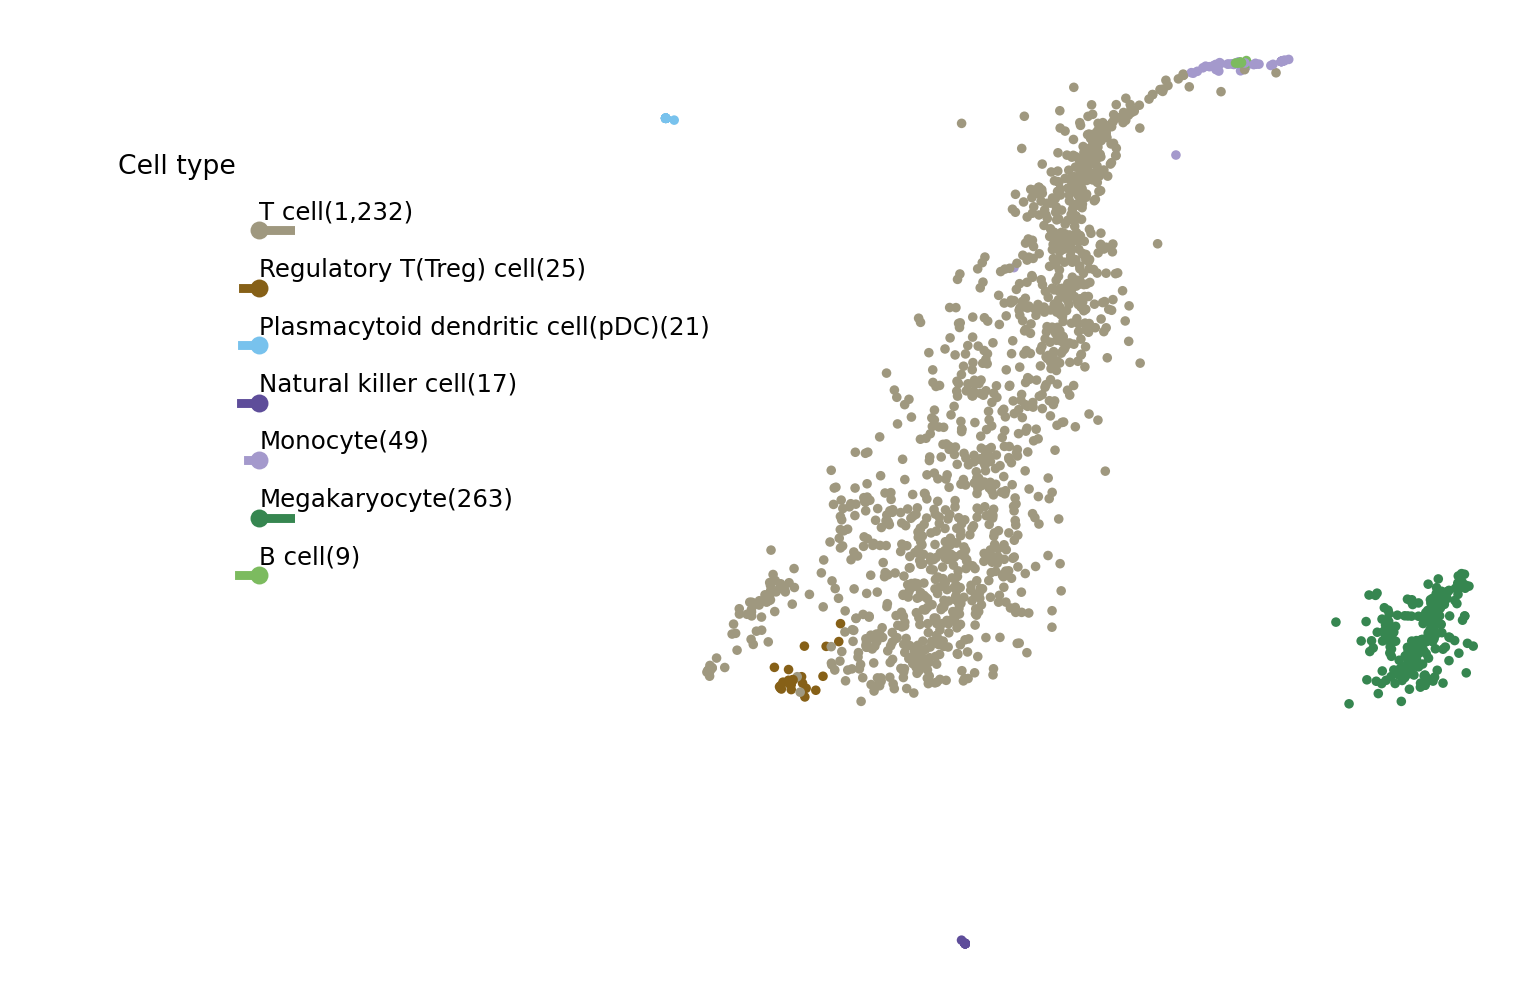

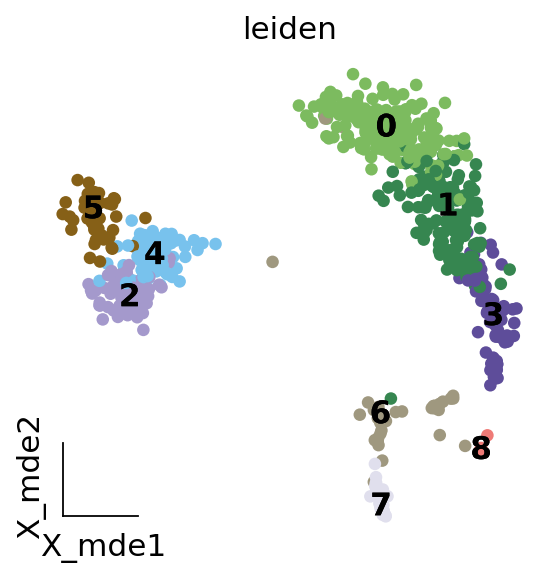

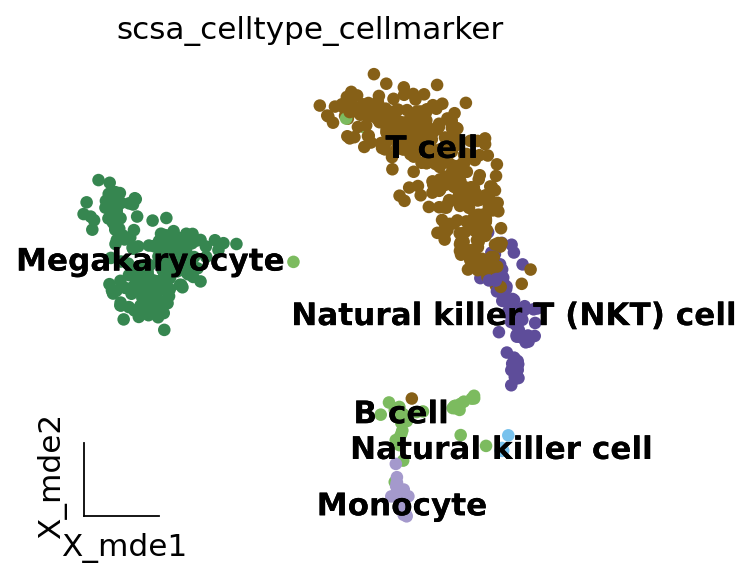

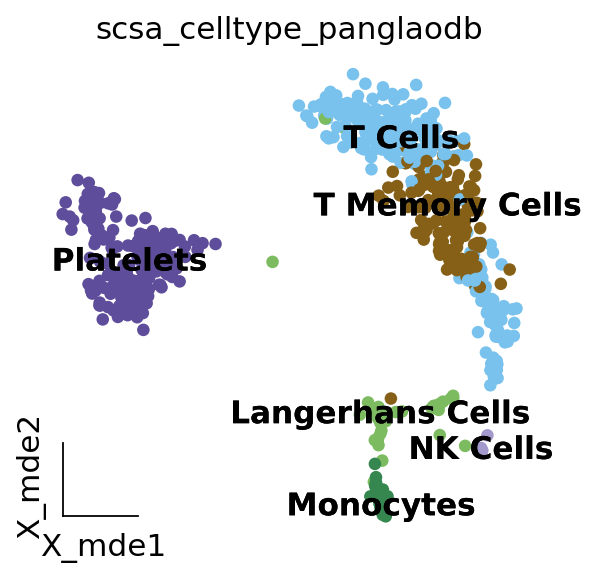

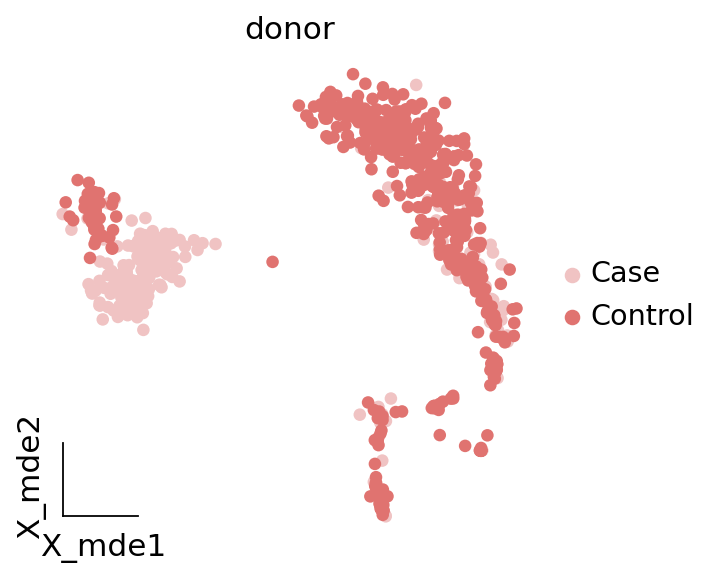

chi2: 395.083945426401, dof: 5, pvalue: 3.402183471381459e-83
Performing t-test
ranking genes
    finished (0:00:00)
Performing wilcoxon
ranking genes
    finished (0:00:00)
Performing logreg
ranking genes
    finished (0:00:00)
Performing t-test_overestim_var
ranking genes
    finished (0:00:00)
Generating DataFrame


				Processing Dataset5 from MPN


 Found 1 Cases and 1 Control Donors

Building Case Adata No. 1 out of 1
... reading from cache file cache/data-MPN-Dataset5-Case-matrix.h5ad
Building Control Adata No. 1 out of 1
... reading from cache file cache/data-MPN-Dataset5-Control3-matrix.h5ad

 AnnData object with n_obs × n_vars = 24650 × 36601
    obs: 'donor' 

Calculate QC metrics
End calculation of QC metrics.
Original cell number: 24650
Begin of post doublets removal and QC plot
Running Scrublet
filtered out 13717 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
normalizi

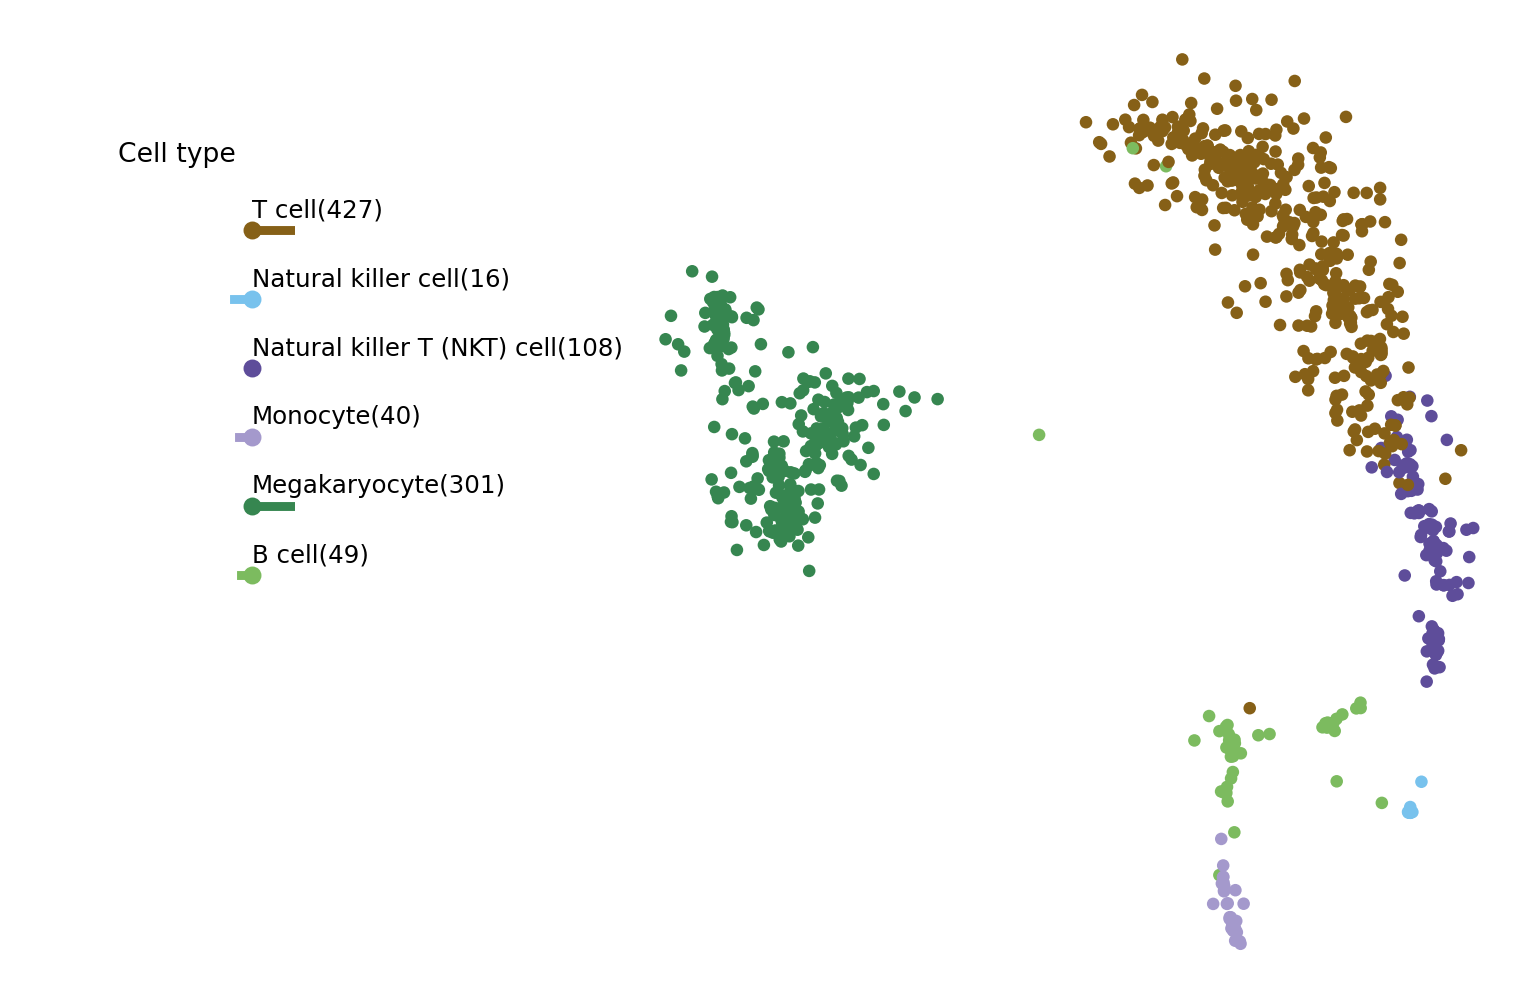

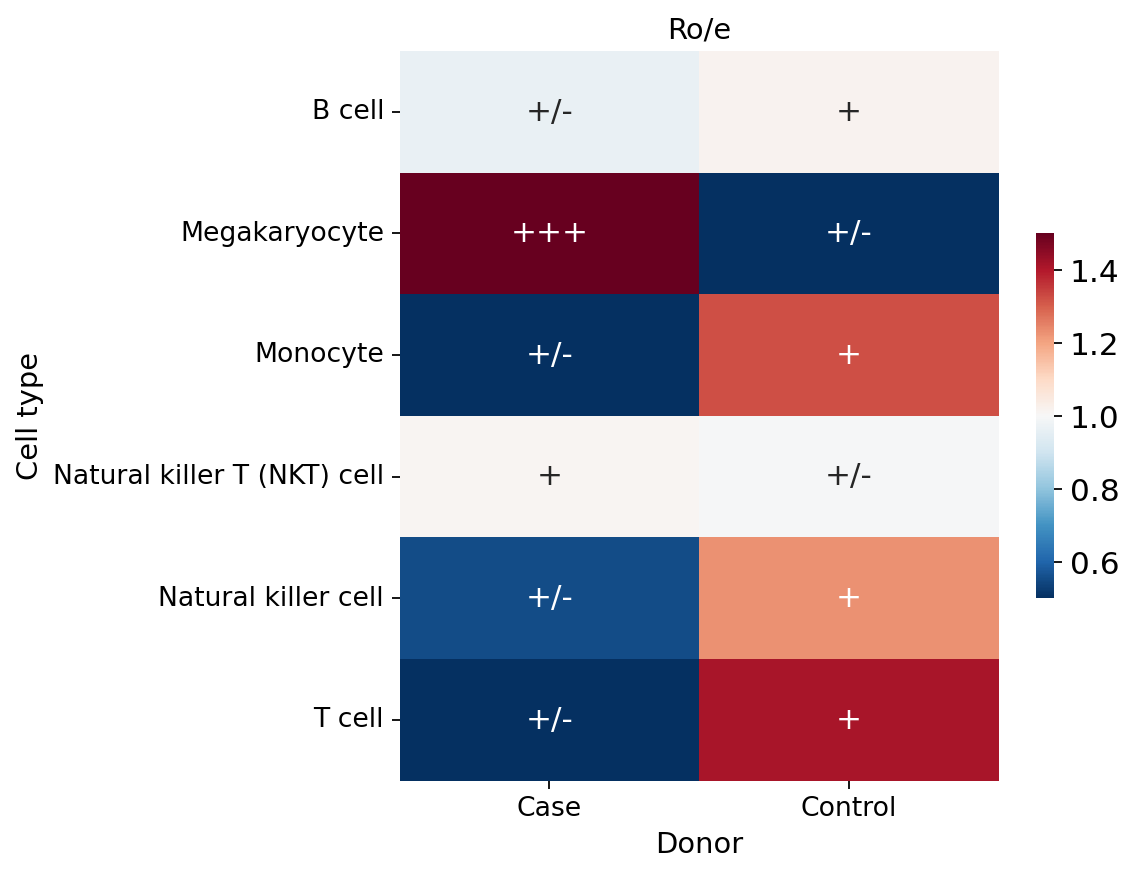

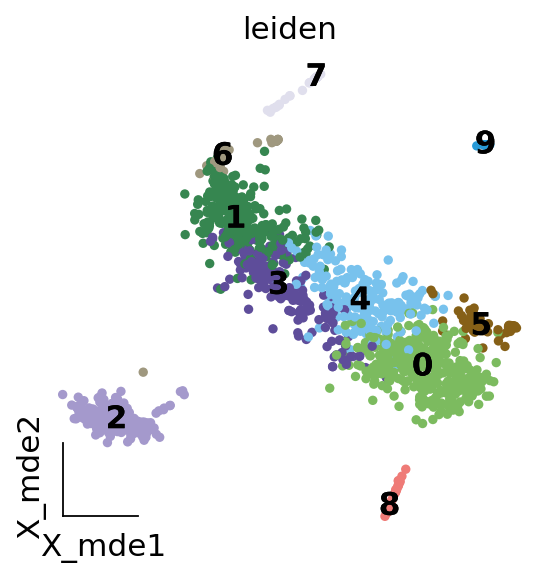

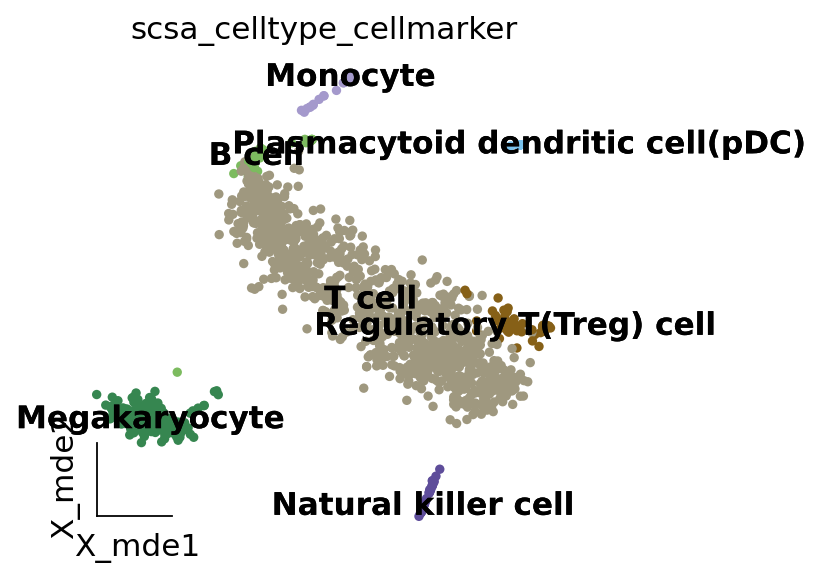

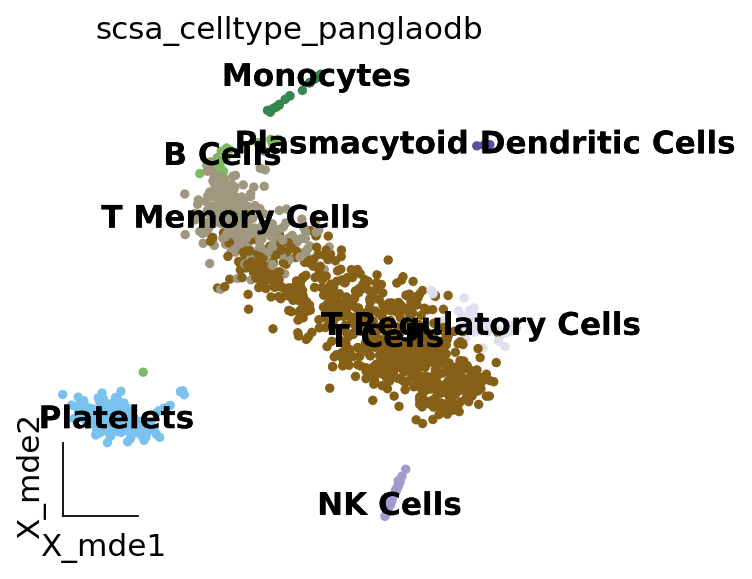

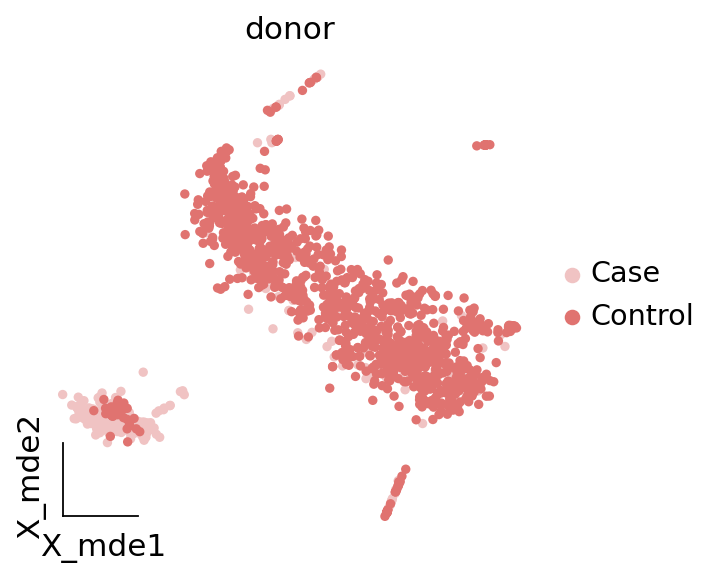

chi2: 967.4389391681444, dof: 6, pvalue: 9.84592111114955e-206
Performing t-test
ranking genes
    finished (0:00:00)
Performing wilcoxon
ranking genes
    finished (0:00:00)
Performing logreg
ranking genes
    finished (0:00:00)
Performing t-test_overestim_var
ranking genes
    finished (0:00:00)
Generating DataFrame

Done!


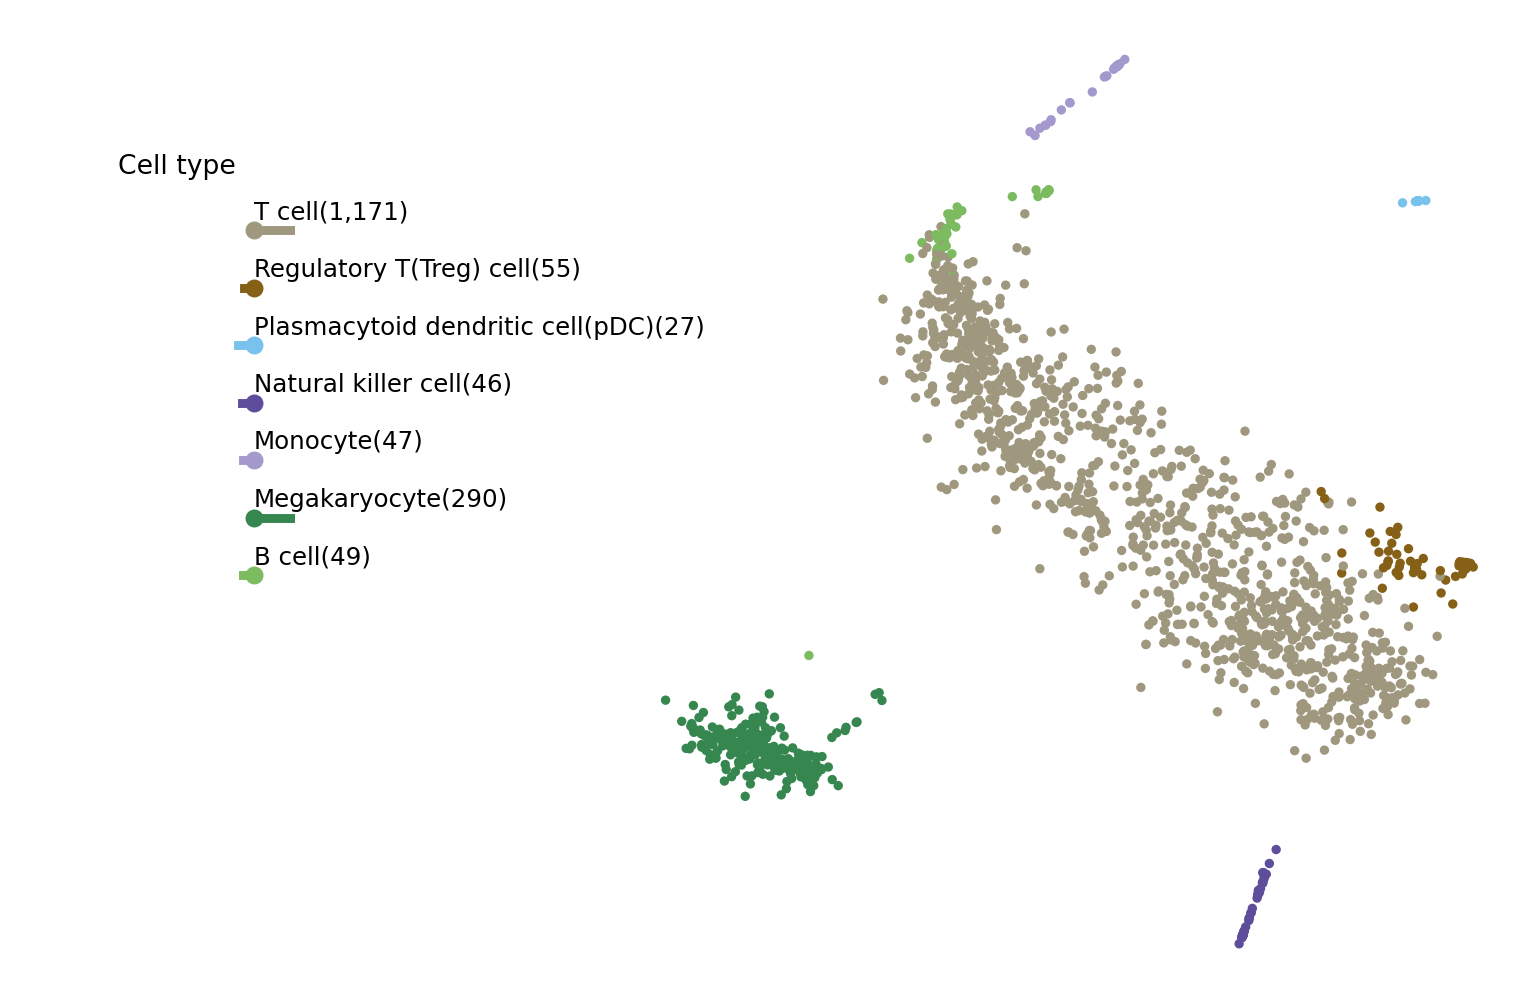

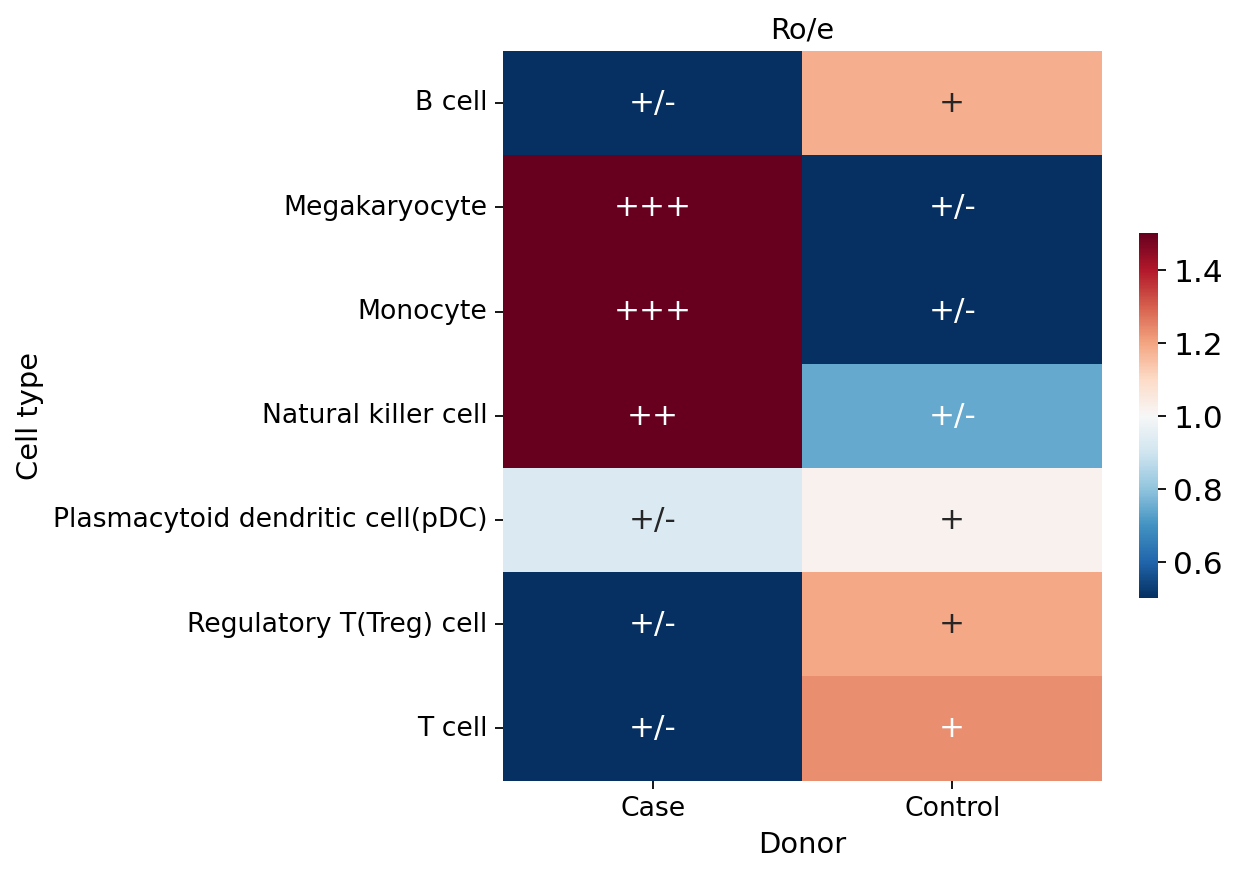

In [16]:
run_pipeline_over_disease(disease_name=DISEASE_NAME)

## Cell annotate manually

In order to compare the accuracy of our automatic annotations, we will here use marker genes to manually annotate the cluster and compare the accuracy of the pySCSA and manual.

We need to prepare a marker's dict at first

In [13]:
res_marker_dict={
    'Megakaryocyte':['ITGA2B','ITGB3'],
    'Dendritic cell':['CLEC10A','IDO1'],
    'Monocyte' :['S100A8','S100A9','LST1',],
    'Macrophage':['CSF1R','CD68'],
    'B cell':['MS4A1','CD79A','MZB1',],
    'NK/NKT cell':['GNLY','KLRD1'],
    'CD8+T cell':['CD8A','CD8B'],
    'Treg':['CD4','CD40LG','IL7R','FOXP3','IL2RA'],
    'CD4+T cell':['PTPRC','CD3D','CD3E'],
}

We then calculated the expression of marker genes in each cluster and the fraction

In [14]:
sc.tl.dendrogram(adata, 'leiden')
sc.pl.dotplot(adata, res_marker_dict, 'leiden',
              dendrogram=True, standard_scale='var')

NameError: name 'adata' is not defined

Based on the dotplot, we name each cluster according `ov.single.scanpy_cellanno_from_dict`

In [ ]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'T cell',
     '1': 'T cell',
     '2': 'Monocyte',#Germ-cell(Oid)
     '3': 'B cell',#Germ-cell(Oid)
     '4': 'T cell',
     '5': 'Macrophage',
     '6': 'NKT cells',
     '7': 'T cell',
    '8':'Monocyte',
    '9':'Dendritic cell',
    '10':'Megakaryocyte',

}

ov.single.scanpy_cellanno_from_dict(adata,anno_dict=cluster2annotation,
                                    clustertype='leiden')

## Compare the pySCSA and Manual

We can see that the auto-annotation results are almost identical to the manual annotation, the only difference is between monocyte and macrophages, but in the previous auto-annotation results, pySCSA gives the option of `monocyte|macrophage`, so it can be assumed that pySCSA performs better on the pbmc3k data

In [ ]:
ov.utils.embedding(adata,
                   basis='X_mde',
                   color=['major_celltype','scsa_celltype_cellmarker', 'scsa_celltype_panglaodb'],
                   legend_loc='on data', frameon='small',legend_fontoutline=2,
                   palette=ov.utils.palette()[14:],
                  )

We can use `get_celltype_marker` to obtain the marker of each celltype

In [ ]:
marker_dict=ov.single.get_celltype_marker(adata,clustertype='scsa_celltype_cellmarker')
marker_dict.keys()

In [ ]:
marker_dict['T cell']

## The tissue name in database

For annotation of cell types in specific tissues, we can query the tissues available in the database using `get_model_tissue`.

In [ ]:
scsa.get_model_tissue()